with reference from : https://www.kaggle.com/slm37102/0-93-multi-category-planet-dataset-fast-ai

In [1]:
from fastai.vision.all import *

In [2]:
path = Path('../input/planets-dataset/planet/planet')

In [3]:
train_df = pd.read_csv(path/'train_classes.csv')
train_df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [4]:
def get_x(r):
    return path/'train-jpg'/(r['image_name']+'.jpg')




In [5]:
def get_y(r):
    return r['tags'].split()


In [6]:
def get_data(size=224, bs=64, data_df=train_df):
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                       splitter=RandomSplitter(seed=42),
                       get_x=get_x,
                       get_y=get_y,
                       item_tfms=Resize(size),
                       batch_tfms=[*aug_transforms(flip_vert=True, max_warp=0),
                                   Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(data_df,bs=bs)

In [7]:
dls = get_data(300, 40)

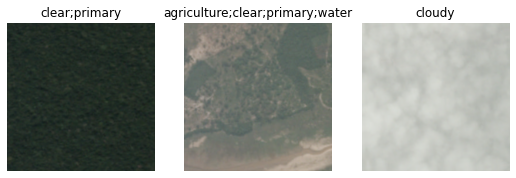

In [8]:
dls.show_batch(nrows=1,ncols=3)

In [9]:
f2samples = FBetaMulti(beta=2, average='samples', thresh=0.2)

In [10]:
metrics = [partial(accuracy_multi, thresh=0.2), f2samples]
cbs = [MixUp]

In [11]:
!pip install wwf -q
!pip install timm -q

In [12]:
from wwf.vision.timm import *

In [13]:
learn = timm_learner(dls, 'efficientnet_b3', metrics=metrics, cbs=cbs)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


In [14]:
learn.fine_tune(12, base_lr=3e-2,freeze_epochs=4)


epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.189556,1.573179,0.923490,0.868529,07:16
1,0.175117,0.815853,0.933990,0.890614,06:43
2,0.169636,0.242508,0.951161,0.892307,06:42
3,0.170679,14.588033,0.952520,0.904011,06:43


epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.151867,20.700893,0.952774,0.911197,08:51
1,0.148737,6.204937,0.957243,0.912786,08:50
2,0.146366,77.422615,0.949562,0.917527,08:50
3,0.147281,1.264093,0.943320,0.911396,08:50
4,0.143721,0.098584,0.955019,0.919248,08:51
5,0.140903,0.109510,0.961261,0.921604,08:50
6,0.137618,75.550758,0.957083,0.922654,08:50
7,0.135837,2.933902,0.958180,0.923902,08:51
8,0.132907,0.090600,0.955724,0.925125,08:52
9,0.123096,7.847790,0.958405,0.924639,08:51


In [15]:
file_path = Path('../input/planets-dataset/test-jpg-additional/test-jpg-additional')
test_path = Path('../input/planets-dataset/planet/planet/test-jpg')
submission_df = pd.read_csv(path/'sample_submission.csv')

In [16]:
testing_path = (submission_df['image_name'] +'.jpg').apply(lambda x: test_path/x if x.startswith('test') else file_path/x)

In [17]:
def prediction(filename='submission.csv', tta=False):
    tst_dl = learn.dls.test_dl(testing_path)
    if tta:
        predictions = learn.tta(dl=tst_dl)
    else :
        predictions = learn.get_preds(dl=tst_dl)
    predlist = [' '.join(learn.dls.vocab[i]) for i in (predictions[0] >0.2)]
    df = submission_df
    df['tags'] = predlist
    df.to_csv(filename, index=False)
    return df